In [2]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [4]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [5]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [6]:
tf.keras.backend.clear_session()

In [7]:
subject = 'Minas_Gerais - Consumo de Cimento (t)'
start_index = 0
split_index = 179
window_size = 36
train_split = split_index + 1 - 12

In [8]:
data = pd.read_csv('2003_raw_Minas_Gerais_input.csv')
pd.set_option('display.max_columns', None)
data = data.replace(-1.0, np.nan)
data

,data,Minas_Gerais - PIB - Per Capita,Minas_Gerais - PIB - Preços de Mercado,Minas_Gerais - PIB - Estadual,Minas_Gerais - PIB - Construção Civil,Minas_Gerais - População,Minas_Gerais - INCC (%),Minas_Gerais - IPCA - Variação mensal durante o Plano Real (%),Minas_Gerais - IGP-DI,Minas_Gerais - Taxa Selic (%),Minas_Gerais - IDH - Longevidade,Minas_Gerais - IDH - Renda,Minas_Gerais - IDH - Educação,Minas_Gerais - NFSP - Fluxo Mensal (Milhões de reais),Minas_Gerais - Estoque liquido de capital fixo - (R$),Minas_Gerais - Desemprego,Minas_Gerais - Produção de Cimento (t),Minas_Gerais - Valor,Minas_Gerais - Consumo de Cimento (t)
0,2003-01-01,1.680898e+07,8.848015e+06,0.916344,1.144728e+07,18343517.0,1.70,12.53,2.70,0.082293,0.759,0.68,0.47,3.46,6.098524e+06,10.107449,NaN,0.3000,247134.0
1,2003-02-01,1.680898e+07,8.848015e+06,0.916344,1.144728e+07,18343517.0,1.51,2.25,2.17,0.088771,0.759,0.68,0.47,3.59,6.172460e+06,10.107449,NaN,0.3200,305708.0
2,2003-03-01,1.680898e+07,8.848015e+06,0.916344,1.144728e+07,18343517.0,1.39,3.86,1.59,0.090733,0.759,0.68,0.47,3.84,6.172460e+06,10.107449,42997.0,0.3200,284168.0
3,2003-04-01,1.680898e+07,8.848015e+06,0.916344,1.144728e+07,18343517.0,1.38,5.13,1.66,0.092749,0.759,0.68,0.47,3.95,6.172460e+06,10.107449,101775.0,0.3200,286594.0
4,2003-05-01,1.680898e+07,8.848015e+06,0.916344,1.144728e+07,18343517.0,0.90,6.15,0.41,0.092758,0.759,0.68,0.47,4.06,6.172460e+06,10.107449,104691.0,0.3200,312455.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,2019-08-01,2.660913e+07,4.489872e+07,1.264653,1.440189e+07,21040662.0,0.58,2.42,-0.01,0.024620,0.880,0.74,0.75,0.69,7.827728e+06,12.300000,240100.0,0.3042,589349.0
200,2019-09-01,2.660913e+07,4.489872e+07,1.264653,1.440189e+07,21040662.0,0.42,2.54,-0.51,0.022751,0.880,0.74,0.75,0.62,7.827728e+06,12.000000,26248.0,0.3040,543982.0
201,2019-10-01,2.660913e+07,4.489872e+07,1.264653,1.440189e+07,21040662.0,0.46,2.49,0.50,0.022035,0.880,0.74,0.75,0.59,7.827728e+06,11.900000,236995.0,0.3020,614074.0
202,2019-11-01,2.660913e+07,4.489872e+07,1.264653,1.440189e+07,21040662.0,0.18,2.60,0.55,0.020790,0.880,0.74,0.75,0.57,7.827728e+06,11.700000,10751.0,0.3020,557419.0


In [9]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data = target_data/1000
target_data

0      268.591
1      246.372
2      292.439
3      310.034
4      322.741
        ...   
199        NaN
200        NaN
201        NaN
202        NaN
203        NaN
Name: Minas_Gerais - Consumo de Cimento (t), Length: 204, dtype: float64

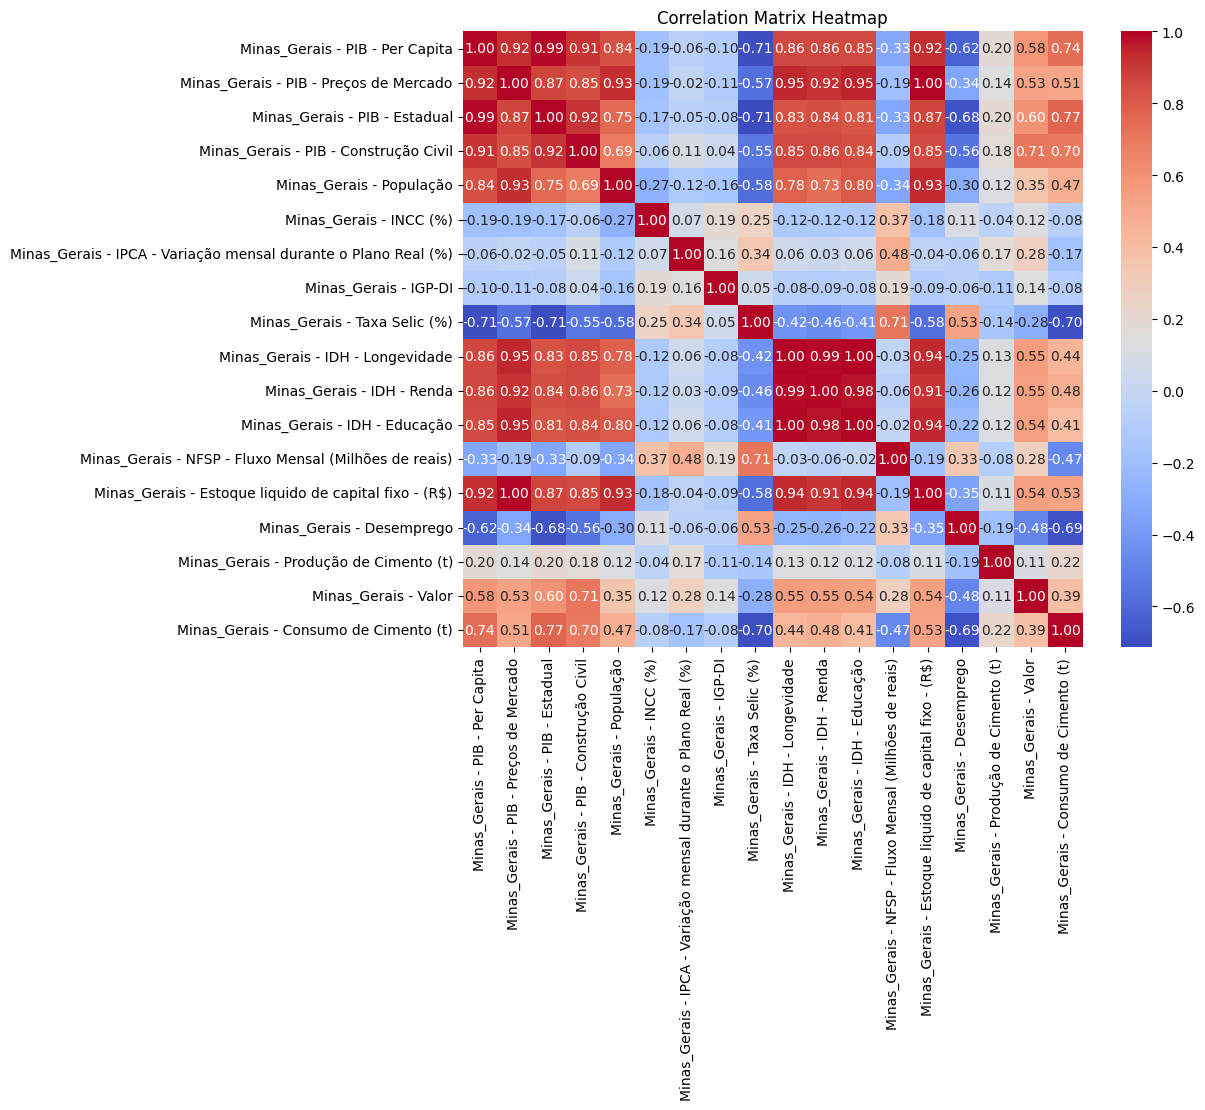

In [10]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [11]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data = input_data.fillna(-1.0)
input_data

,Minas_Gerais - PIB - Per Capita,Minas_Gerais - PIB - Preços de Mercado,Minas_Gerais - PIB - Estadual,Minas_Gerais - PIB - Construção Civil,Minas_Gerais - População,Minas_Gerais - INCC (%),Minas_Gerais - IPCA - Variação mensal durante o Plano Real (%),Minas_Gerais - IGP-DI,Minas_Gerais - Taxa Selic (%),Minas_Gerais - IDH - Longevidade,Minas_Gerais - IDH - Renda,Minas_Gerais - IDH - Educação,Minas_Gerais - NFSP - Fluxo Mensal (Milhões de reais),Minas_Gerais - Estoque liquido de capital fixo - (R$),Minas_Gerais - Desemprego,Minas_Gerais - Produção de Cimento (t),Minas_Gerais - Valor
0,-1.691290,-1.409946,-1.607340,-0.764016,-1.790633,1.998868,4.052332,3.466715,2.303195,-0.920816,-0.931381,-0.909553,3.108599,-1.539424,1.131050,-1.000000,-0.112490
1,-1.691290,-1.409946,-1.607340,-0.764016,-1.790633,1.647487,-0.596188,2.630940,2.745235,-0.920816,-0.931381,-0.909553,3.275709,-1.411460,1.131050,-1.000000,0.211689
2,-1.691290,-1.409946,-1.607340,-0.764016,-1.790633,1.425561,0.131839,1.716318,2.879123,-0.920816,-0.931381,-0.909553,3.597074,-1.411460,1.131050,-0.669405,0.211689
3,-1.691290,-1.409946,-1.607340,-0.764016,-1.790633,1.407068,0.706121,1.826703,3.016721,-0.920816,-0.931381,-0.909553,3.738475,-1.411460,1.131050,-0.467675,0.211689
4,-1.691290,-1.409946,-1.607340,-0.764016,-1.790633,0.519367,1.167355,-0.144465,3.017322,-0.920816,-0.931381,-0.909553,3.879875,-1.411460,1.131050,-0.457668,0.211689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.539933,1.517213,0.227214,0.140903,1.605997,-0.590259,-0.966985,-1.264088,-0.729479,1.357280,1.397071,1.473170,-0.374997,1.441346,2.365558,-0.292194,-0.566341
176,0.539933,1.517213,0.227214,0.140903,1.605997,-0.479297,-0.881068,-0.412544,-0.941281,1.357280,1.397071,1.473170,-0.439270,1.441346,2.365558,-0.709018,-0.663594
177,0.539933,1.517213,0.227214,0.140903,1.605997,-1.034110,-0.808718,0.186692,-1.140710,1.357280,1.397071,1.473170,-0.503543,1.441346,2.365558,-0.211726,-0.631177
178,0.539933,1.517213,0.227214,0.140903,1.605997,-0.571766,-0.614276,-0.633314,-1.226481,1.357280,1.397071,1.473170,-0.503543,1.441346,2.434427,-0.776393,-0.507989


In [12]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Minas_Gerais - PIB - Per Capita,Minas_Gerais - PIB - Preços de Mercado,Minas_Gerais - PIB - Estadual,Minas_Gerais - PIB - Construção Civil,Minas_Gerais - População,Minas_Gerais - INCC (%),Minas_Gerais - IPCA - Variação mensal durante o Plano Real (%),Minas_Gerais - IGP-DI,Minas_Gerais - Taxa Selic (%),Minas_Gerais - IDH - Longevidade,Minas_Gerais - IDH - Renda,Minas_Gerais - IDH - Educação,Minas_Gerais - NFSP - Fluxo Mensal (Milhões de reais),Minas_Gerais - Estoque liquido de capital fixo - (R$),Minas_Gerais - Desemprego,Minas_Gerais - Produção de Cimento (t),Minas_Gerais - Valor
0,-1.691290,-1.409946,-1.60734,-0.764016,-1.790633,1.998868,4.052332,3.466715,2.303195,-0.920816,-0.931381,-0.909553,3.108599,-1.539424,1.131050,-1.000000,-0.112490
1,-1.691290,-1.409946,-1.60734,-0.764016,-1.790633,1.647487,-0.596188,2.630940,2.745235,-0.920816,-0.931381,-0.909553,3.275709,-1.411460,1.131050,-1.000000,0.211689
2,-1.691290,-1.409946,-1.60734,-0.764016,-1.790633,1.425561,0.131839,1.716318,2.879123,-0.920816,-0.931381,-0.909553,3.597074,-1.411460,1.131050,-0.669405,0.211689
3,-1.691290,-1.409946,-1.60734,-0.764016,-1.790633,1.407068,0.706121,1.826703,3.016721,-0.920816,-0.931381,-0.909553,3.738475,-1.411460,1.131050,-0.467675,0.211689
4,-1.691290,-1.409946,-1.60734,-0.764016,-1.790633,0.519367,1.167355,-0.144465,3.017322,-0.920816,-0.931381,-0.909553,3.879875,-1.411460,1.131050,-0.457668,0.211689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,0.762892,1.351868,0.53295,0.623395,1.441596,-0.238878,0.629248,-1.406012,0.272188,1.357280,1.008996,1.384921,0.794771,1.416222,0.299494,-1.000000,0.697957
164,0.762892,1.351868,0.53295,0.623395,1.441596,-0.608753,0.837256,-0.112926,0.272188,1.357280,1.008996,1.384921,0.730498,1.416222,0.368363,-1.000000,0.600704
165,0.762892,1.351868,0.53295,0.623395,1.441596,-0.534778,0.877953,-0.743700,0.272188,1.357280,1.008996,1.384921,0.743353,1.416222,0.437232,-1.000000,0.373778
166,0.762892,1.351868,0.53295,0.623395,1.441596,-0.756703,1.000045,-0.586006,0.248413,1.357280,1.008996,1.384921,0.614807,1.416222,0.437232,-1.000000,0.224656


In [13]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      268.591
1      246.372
2      292.439
3      310.034
4      322.741
        ...   
163    537.851
164    526.265
165    559.293
166    466.646
167    416.049
Name: Minas_Gerais - Consumo de Cimento (t), Length: 168, dtype: float64

In [14]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [15]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(132, 36, 17)

In [16]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Minas_Gerais - PIB - Per Capita,Minas_Gerais - PIB - Preços de Mercado,Minas_Gerais - PIB - Estadual,Minas_Gerais - PIB - Construção Civil,Minas_Gerais - População,Minas_Gerais - INCC (%),Minas_Gerais - IPCA - Variação mensal durante o Plano Real (%),Minas_Gerais - IGP-DI,Minas_Gerais - Taxa Selic (%),Minas_Gerais - IDH - Longevidade,Minas_Gerais - IDH - Renda,Minas_Gerais - IDH - Educação,Minas_Gerais - NFSP - Fluxo Mensal (Milhões de reais),Minas_Gerais - Estoque liquido de capital fixo - (R$),Minas_Gerais - Desemprego,Minas_Gerais - Produção de Cimento (t),Minas_Gerais - Valor
132,1.364047,1.126746,1.346141,1.447825,1.088699,-0.960135,1.058830,0.297077,-0.755853,1.152046,1.008996,1.031925,-0.285015,0.834026,-0.802406,2.411301,1.038345
133,1.364047,1.126746,1.346141,1.447825,1.088699,0.482379,-1.364912,-0.160234,-0.688658,1.152046,1.008996,1.031925,-0.349288,1.129318,-0.458062,-1.000000,1.054554
134,1.364047,1.126746,1.346141,1.447825,1.088699,-0.534778,-1.052901,0.549386,-0.626634,1.152046,1.008996,1.031925,-0.374997,1.129318,-0.251456,-0.638764,1.054554
135,1.364047,1.126746,1.346141,1.447825,1.088699,-0.627247,-0.627842,1.542855,-0.571481,1.152046,1.008996,1.031925,-0.259306,1.129318,-0.389193,-1.000000,1.054554
136,1.364047,1.126746,1.346141,1.447825,1.088699,0.482379,-0.320352,-0.081387,-0.516512,1.152046,1.008996,1.031925,-0.053632,1.129318,-0.526931,-1.000000,1.054554
137,1.364047,1.126746,1.346141,1.447825,1.088699,2.646150,-0.107822,-1.500628,-0.510405,1.152046,1.008996,1.031925,0.023495,1.129318,-0.664669,-1.000000,1.054554
138,1.364047,1.126746,1.346141,1.447825,1.088699,0.075516,0.082098,-1.784477,-0.510405,1.152046,1.008996,1.031925,-0.002214,1.129318,-0.733537,3.140439,1.213402
139,1.364047,1.126746,1.346141,1.447825,1.088699,0.241960,0.086620,-1.658322,-0.510405,1.152046,1.008996,1.031925,-0.143614,1.129318,-0.871275,-1.000000,1.213402
140,1.364047,1.126746,1.346141,1.447825,1.088699,-0.997122,0.204189,-0.696392,-0.510054,1.152046,1.008996,1.031925,-0.182178,1.129318,-1.009013,-1.000000,1.151808
141,1.364047,1.126746,1.346141,1.447825,1.088699,-0.867666,0.470982,-0.759469,-0.510405,1.152046,1.008996,1.031925,-0.105051,1.129318,-1.146750,-1.000000,1.119390


In [17]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 17)

In [18]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(144, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(144, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.1,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [18]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [19]:
def predictor(model, test_input, test_target, start_target):
    
    predictions = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        if (prediction[0][0] < 0.0):
            return None, None
        predictions.append(prediction[0][0])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    return df_results, predictions

In [20]:
def statistical_validator(train_input, train_target, test_input, test_target, start_target):
    
    pd.set_option('display.max_columns', None)
    predictions_list = []
    error_percent = []
    
    i = 0
    while i < 10:
        winner_seed = get_a_good_seed(train_input, train_target, test_input, test_target)
        trained_model, history = lstm_model(train_input, 
                                            train_target, 
                                            want_verbose=0, 
                                            seed=winner_seed)
        df_results, predictions = predictor(trained_model, 
                                            test_input, 
                                            test_target, 
                                            start_index)
        if predictions is not None:
            display(df_results.T)
            predictions_list.append(predictions)
            i += 1
        
    predictions_means = np.mean(predictions_list, axis=0)
    results_data = []
   
    for j in range(12):
        target = test_target[start_target + j]
        error = np.abs(predictions_means[j] - target)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                            predictions_means[j], 
                            target, 
                            error])
    display("FINAL___________________________________________________________________")
    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])
    display(df_results.T)
        
    mae_mean = np.mean(predictions_means)
    mape_mean = np.mean(error_percent) 

    return mae_mean, mape_mean

In [22]:
mae, mape = statistical_validator(reshaped_train, 
                                  reshaped_target, 
                                  reshaped_test, 
                                  reshaped_test_target, 
                                  start_index)

[430113606, 77445779, 443698786, 162690737, 33243878, 2784849751, 3343229192, 1790881482, 2109302725, 1541080429]


Step: 0 ___________________________________________
val_loss: 6066.91015625
winner_seed: 430113606


Step: 1 ___________________________________________
val_loss: 10766.162109375


Step: 2 ___________________________________________
val_loss: 13011.1923828125


Step: 3 ___________________________________________
val_loss: 7953.3017578125


Step: 4 ___________________________________________
val_loss: 5608.32861328125
winner_seed: 33243878


Step: 5 ___________________________________________
val_loss: 5054.73974609375
winner_seed: 2784849751


Step: 6 ___________________________________________
val_loss: 8190.7646484375


Step: 7 ___________________________________________
val_loss: 6926.1533203125


Step: 8 ___________________________________________
val_loss: 437563232.0


Step: 9 ___________________________________________
val_loss: 116566.8984375
1/1 [================

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,413.200745,413.10257,417.853882,433.58136,449.783508,431.214264,431.453827,465.015472,450.533783,449.486542,441.957977,435.738739
Target,501.489,460.699,445.583,509.271,532.602,500.905,588.495,589.349,543.982,614.074,557.419,412.582
Error,88.288269,47.596436,27.729126,75.689636,82.818481,69.690735,157.041168,124.333527,93.448212,164.587433,115.461029,23.156738


[3662228696, 1341392980, 842068734, 1797373376, 3434240161, 1517107024, 1213890838, 3706220147, 1724250526, 2680926696]


Step: 0 ___________________________________________
val_loss: 6330.3017578125
winner_seed: 3662228696


Step: 1 ___________________________________________
val_loss: 9028.498046875


Step: 2 ___________________________________________
val_loss: 8327.7587890625


Step: 3 ___________________________________________
val_loss: 7704.8720703125


Step: 4 ___________________________________________
val_loss: 7630.9833984375


Step: 5 ___________________________________________
val_loss: 25301.578125


Step: 6 ___________________________________________
val_loss: 7504.0908203125


Step: 7 ___________________________________________
val_loss: 7468.4619140625


Step: 8 ___________________________________________
val_loss: 7995.3349609375


Step: 9 ___________________________________________
val_loss: 5252.0751953125
winner_seed: 2680926696
1/1 [==============================]

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,433.074158,402.40271,451.727905,479.752441,455.431702,447.437744,468.853271,520.051575,481.313477,448.114258,439.071716,433.514221
Target,501.489,460.699,445.583,509.271,532.602,500.905,588.495,589.349,543.982,614.074,557.419,412.582
Error,68.414856,58.296295,6.144897,29.518555,77.170288,53.467255,119.641724,69.297424,62.668518,165.959717,118.34729,20.93222


[531171348, 2463530771, 3017553653, 36486683, 1714829040, 4233782111, 1999848619, 3528155325, 263560900, 1512949922]


Step: 0 ___________________________________________
val_loss: 10408.740234375
winner_seed: 531171348


Step: 1 ___________________________________________
val_loss: 5809.80810546875
winner_seed: 2463530771


Step: 2 ___________________________________________
val_loss: 5601.4228515625
winner_seed: 3017553653


Step: 3 ___________________________________________
val_loss: 50446.08203125


Step: 4 ___________________________________________
val_loss: 6602.0693359375


Step: 5 ___________________________________________
val_loss: 7274.8037109375


Step: 6 ___________________________________________
val_loss: 5685.01806640625


Step: 7 ___________________________________________
val_loss: 8304189.0


Step: 8 ___________________________________________
val_loss: 8882.69921875


Step: 9 ___________________________________________
val_loss: 22129.626953125
1/1 [==============

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,421.166626,415.598572,451.022522,454.702576,450.459106,451.080536,454.333923,455.800232,452.741119,449.000977,442.917114,442.583008
Target,501.489,460.699,445.583,509.271,532.602,500.905,588.495,589.349,543.982,614.074,557.419,412.582
Error,80.322388,45.100433,5.439514,54.56842,82.142883,49.824463,134.161072,133.548767,91.240875,165.072998,114.501892,30.001007


[13474654, 1971800185, 2974528504, 3599196554, 2064369381, 3537122524, 4073896856, 3846551659, 3124393796, 3140599648]


Step: 0 ___________________________________________
val_loss: 47091.22265625
winner_seed: 13474654


Step: 1 ___________________________________________
val_loss: 7491920.0


Step: 2 ___________________________________________
val_loss: 341480.46875


Step: 3 ___________________________________________
val_loss: 5561.34619140625
winner_seed: 3599196554


Step: 4 ___________________________________________
val_loss: 5852.7021484375


Step: 5 ___________________________________________
val_loss: 5994.22998046875


Step: 6 ___________________________________________
val_loss: 19603966.0


Step: 7 ___________________________________________
val_loss: 32691.171875


Step: 8 ___________________________________________
val_loss: 5711.4150390625


Step: 9 ___________________________________________
val_loss: 75189120.0
1/1 [==============================] - 0s 15ms/step


,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,405.858368,365.566772,448.054779,450.666565,442.357574,446.570221,439.370209,458.696747,434.794006,440.017731,412.423492,447.59903
Target,501.489,460.699,445.583,509.271,532.602,500.905,588.495,589.349,543.982,614.074,557.419,412.582
Error,95.630646,95.132233,2.471771,58.604431,90.244415,54.334778,149.124786,130.652252,109.187988,174.056244,144.995514,35.017029


[417370462, 3266665538, 2487414848, 1357218018, 2788988788, 641466474, 2495569247, 1180710570, 93539616, 508226170]


Step: 0 ___________________________________________
val_loss: 5674.93994140625
winner_seed: 417370462


Step: 1 ___________________________________________
val_loss: 8395.421875


Step: 2 ___________________________________________
val_loss: 7999.0224609375


Step: 3 ___________________________________________
val_loss: 1142280.625


Step: 4 ___________________________________________
val_loss: 13391.720703125


Step: 5 ___________________________________________
val_loss: 6925.56005859375


Step: 6 ___________________________________________
val_loss: 8739.8505859375


Step: 7 ___________________________________________
val_loss: 6822.62109375


Step: 8 ___________________________________________
val_loss: 14399.5283203125


Step: 9 ___________________________________________
val_loss: 5126.45263671875
winner_seed: 508226170
1/1 [==============================] - 0s 15

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,449.500946,358.559143,396.648071,416.111084,415.566101,452.467285,442.420929,430.791962,451.871826,447.461731,413.270538,408.507812
Target,501.489,460.699,445.583,509.271,532.602,500.905,588.495,589.349,543.982,614.074,557.419,412.582
Error,51.988068,102.139862,48.934937,93.159912,117.035889,48.437714,146.074066,158.557037,92.110168,166.612244,144.148468,4.074188


[3112690547, 2724556416, 1245373996, 1751548536, 3300672256, 629129815, 1099456516, 614099255, 3594588082, 804972370]


Step: 0 ___________________________________________
val_loss: 6677.14599609375
winner_seed: 3112690547


Step: 1 ___________________________________________
val_loss: 6315.32470703125
winner_seed: 2724556416


Step: 2 ___________________________________________
val_loss: 2778527.5


Step: 3 ___________________________________________
val_loss: 10950120.0


Step: 4 ___________________________________________
val_loss: 8065.11181640625


Step: 5 ___________________________________________
val_loss: 6808853.5


Step: 6 ___________________________________________
val_loss: 6454.34619140625


Step: 7 ___________________________________________
val_loss: 4835.52587890625
winner_seed: 614099255


Step: 8 ___________________________________________
val_loss: 6410.4599609375


Step: 9 ___________________________________________
val_loss: 8651.845703125
1/1 [===================

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,417.218933,362.665466,381.64386,472.146423,433.228638,434.733582,469.958862,436.682922,469.996643,469.953979,470.607727,484.187317
Target,501.489,460.699,445.583,509.271,532.602,500.905,588.495,589.349,543.982,614.074,557.419,412.582
Error,84.270081,98.033539,63.939148,37.124573,99.373352,66.171417,118.536133,152.666077,73.985352,144.119995,86.811279,71.605316


[2473446171, 203699559, 3689691734, 1015139574, 3287776903, 1288946553, 880549877, 4210916907, 2802168193, 490149670]


Step: 0 ___________________________________________
val_loss: 189453.921875
winner_seed: 2473446171


Step: 1 ___________________________________________
val_loss: 12328.142578125
winner_seed: 203699559


Step: 2 ___________________________________________
val_loss: 8228.001953125
winner_seed: 3689691734


Step: 3 ___________________________________________
val_loss: 13323.9130859375


Step: 4 ___________________________________________
val_loss: 9687.421875


Step: 5 ___________________________________________
val_loss: 11819.3779296875


Step: 6 ___________________________________________
val_loss: 225736.796875


Step: 7 ___________________________________________
val_loss: 30798.390625


Step: 8 ___________________________________________
val_loss: 18441.17578125


Step: 9 ___________________________________________
val_loss: 6327.20263671875
winner_seed: 49014967

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,414.084473,404.804199,436.367584,444.588959,444.588379,444.58783,444.588959,467.266113,444.589081,444.588409,444.588898,444.588898
Target,501.489,460.699,445.583,509.271,532.602,500.905,588.495,589.349,543.982,614.074,557.419,412.582
Error,87.404541,55.894806,9.215424,64.682037,88.013611,56.317169,143.906036,122.082886,99.392914,169.485565,112.830109,32.006897


[1544703584, 4056368933, 324592751, 800579832, 1067520103, 2257217129, 115763091, 2094681133, 2524376575, 365895553]


Step: 0 ___________________________________________
val_loss: 10521.373046875
winner_seed: 1544703584


Step: 1 ___________________________________________
val_loss: 8843.0634765625
winner_seed: 4056368933


Step: 2 ___________________________________________
val_loss: 5913.45654296875
winner_seed: 324592751


Step: 3 ___________________________________________
val_loss: 5273.5234375
winner_seed: 800579832


Step: 4 ___________________________________________
val_loss: 8609.0439453125


Step: 5 ___________________________________________
val_loss: 6117.3046875


Step: 6 ___________________________________________
val_loss: 6475.95654296875


Step: 7 ___________________________________________
val_loss: 5858.7861328125


Step: 8 ___________________________________________
val_loss: 11050.8798828125


Step: 9 ___________________________________________
val_loss: 6418.805

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,378.876068,336.049683,435.617798,470.683228,386.58551,384.299194,407.978271,443.464417,441.92865,418.823334,467.184845,455.398987
Target,501.489,460.699,445.583,509.271,532.602,500.905,588.495,589.349,543.982,614.074,557.419,412.582
Error,122.612946,124.649323,9.96521,38.587769,146.016479,116.605804,180.516724,145.884583,102.053345,195.250641,90.234161,42.816986


[1409333905, 1059641408, 642882961, 1223516941, 1268129946, 4249824403, 1062210178, 2810368361, 2849657079, 2518195139]


Step: 0 ___________________________________________
val_loss: 9051.0703125
winner_seed: 1409333905


Step: 1 ___________________________________________
val_loss: 8241.3681640625
winner_seed: 1059641408


Step: 2 ___________________________________________
val_loss: 7201.14697265625
winner_seed: 642882961


Step: 3 ___________________________________________
val_loss: 32345.515625


Step: 4 ___________________________________________
val_loss: 7445.13818359375


Step: 5 ___________________________________________
val_loss: 6388.77783203125
winner_seed: 4249824403


Step: 6 ___________________________________________
val_loss: 5617.09619140625
winner_seed: 1062210178


Step: 7 ___________________________________________
val_loss: 6221.24462890625


Step: 8 ___________________________________________
val_loss: 4920.01611328125
winner_seed: 2849657079


Step: 9 _______

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,459.94931,459.601044,459.895508,461.183441,460.334442,461.103119,462.366486,462.494781,462.178436,463.159485,461.997498,463.680328
Target,501.489,460.699,445.583,509.271,532.602,500.905,588.495,589.349,543.982,614.074,557.419,412.582
Error,41.539703,1.097961,14.3125,48.087555,72.267548,39.80188,126.12851,126.854218,81.803558,150.91449,95.421509,51.098328


[3657506614, 2261025359, 3149687361, 2877357631, 799974535, 2782424589, 559844030, 1925789264, 2252489927, 1332819475]


Step: 0 ___________________________________________
val_loss: 6110.3876953125
winner_seed: 3657506614


Step: 1 ___________________________________________
val_loss: 8087.79443359375


Step: 2 ___________________________________________
val_loss: 13493.9853515625


Step: 3 ___________________________________________
val_loss: 7128.1328125


Step: 4 ___________________________________________
val_loss: 57560.9453125


Step: 5 ___________________________________________
val_loss: 5986.8193359375
winner_seed: 2782424589


Step: 6 ___________________________________________
val_loss: 7974.67529296875


Step: 7 ___________________________________________
val_loss: 10726.7236328125


Step: 8 ___________________________________________
val_loss: 6880.78369140625


Step: 9 ___________________________________________
val_loss: 8787.08984375
1/1 [==============================

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,456.753235,456.805695,456.745636,457.212494,473.716736,488.630402,487.130066,490.324768,487.736877,486.193512,485.659607,486.026947
Target,501.489,460.699,445.583,509.271,532.602,500.905,588.495,589.349,543.982,614.074,557.419,412.582
Error,44.735779,3.893311,11.162628,52.058502,58.885254,12.274597,101.364929,99.024231,56.245117,127.880463,71.759399,73.444946


'FINAL___________________________________________________________________'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11
Prediction,424.968262,397.515564,433.55777,454.062836,441.20517,444.212402,450.845459,463.058899,457.768402,451.679993,447.967926,450.182526
Target,501.489,460.699,445.583,509.271,532.602,500.905,588.495,589.349,543.982,614.074,557.419,412.582
Error,76.520738,63.183436,12.02523,55.208164,91.39683,56.692598,137.649541,126.290101,86.213598,162.394007,109.451074,37.600526


In [23]:
display(mae)
display(mape)

443.08545

0.15571071505066067